# Example 12 - Using different DOE methods for PFR yield optimization

In this notebook, we will compare the outcomes for PFR yield optimization using different DOE methods. By comparing to Example 5, additional DOE methods including Box-Behnken design, Central-Composite design, and Sobol sequence.

Note: this notebook requires ax and pyDOE2 to be install first. See instructions on the [Ax](https://ax.dev/) and [PyDOE2](https://github.com/clicumu/pyDOE2) documentation page. 

## 1. Import packages

In [1]:
import numpy as np
import sys, os
import time
from IPython.display import display
import pprint
import pyDOE2 as DOE

pp = pprint.PrettyPrinter(indent=4)

from ax import *
from ax.modelbridge.registry import Models
from ax.modelbridge.factory import get_sobol
from nextorch import plotting, bo, doe, utils, io


## 2. Define the objective function and the design space

In [2]:
#%% Define the objective function
#%% Define the objective function
project_path = os.path.abspath(os.path.join(os.getcwd(), '..\..'))
sys.path.insert(0, project_path)

# Set the path for objective function
objective_path = os.path.join(project_path, 'examples', 'PFR')
sys.path.insert(0, objective_path)
from fructose_pfr_model_function import Reactor

def PFR_yield(X_real):
    """PFR model

    Parameters
    ----------
    X_real : numpy matrix
        reactor parameters: 
        T, pH and tf in real scales

    Returns
    -------
    Y_real: numpy matrix
        reactor yield 
    """
    if len(X_real.shape) < 2:
        X_real = np.expand_dims(X_real, axis=1) #If 1D, make it 2D array
        
    Y_real = []
    for i, xi in enumerate(X_real):
        Conditions = {'T_degC (C)': xi[0], 'pH': xi[1], 'tf (min)' : 10**xi[2]}
        yi, _ = Reactor(**Conditions) # only keep the first output       
        Y_real.append(yi)
            
    Y_real = np.array(Y_real)
    # Put y in a column
    Y_real = np.expand_dims(Y_real, axis=1)
        
    return Y_real # yield

# Objective function
objective_func = PFR_yield


#%% Define the design space
# Three input temperature C, pH, log10(residence time)
x_name_simple = ['T', 'pH', 'tf']
X_name_list = ['T', 'pH', r'$\rm log_{10}(tf_{min})$']
X_units = [r'$\rm ^{o}C $', '', '']

# Add the units
X_name_with_unit = []
for i, var in enumerate(X_name_list):
    if not X_units[i]  == '':
        var = var + ' ('+ X_units[i] + ')'
    X_name_with_unit.append(var)
    
# One output
Y_name_with_unit = 'Yield %'

# combine X and Y names
var_names = X_name_with_unit + [Y_name_with_unit]

# Set the operating range for each parameter
X_ranges =  [[140, 200], # Temperature ranges from 140-200 degree C
             [0, 1], # pH values ranges from 0-1 
             [-2, 2]] # log10(residence time) ranges from -2-2  

# Set the reponse range
Y_plot_range = [0, 50]

# Get the information of the design space
n_dim = len(X_name_list) # the dimension of inputs
n_objective = 1 # the dimension of outputs

## 3. Define the initial sampling plan
Here we compare 6 sampling plans with the same number of sampling points:

1. Full factorial (FF) design with levels of 4 and 64 points in total. 
2. Latin hypercube (LHC) design with 10 initial sampling points, and 54 more Bayesian Optimization trials
3. Completely random (RND) samping with 64 points
4. Box-Behnken design (BB)
5. Central-Composite design (CC)
6. Sobol sequence (Sobol)

The initial reponse in a real scale `Y_init_real` is computed from the helper function `bo.eval_objective_func(X_init, X_ranges, objective_func)`, given `X_init` in unit scales. It might throw warning messages since the model solves some edge cases of ODEs given certain input combinations. 

C:\Users\yifan\Anaconda3\envs\torch\lib\site-packages\scipy\integrate\_ode.py:1182: UserWarning:

dopri5: larger nsteps is needed



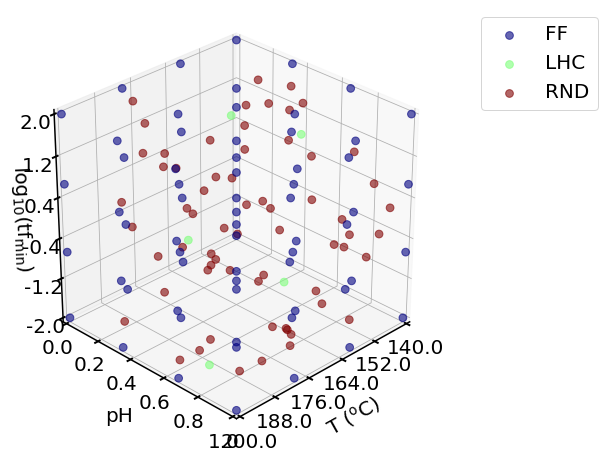

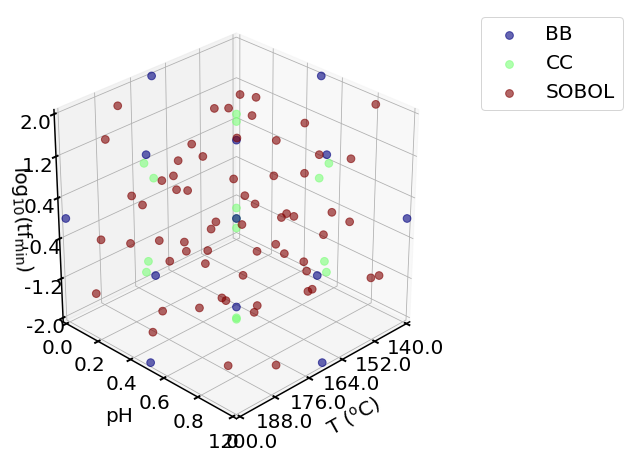

In [3]:
#%% Initial Sampling 
# Full factorial design 
n_ff_level = 4
n_total = n_ff_level**n_dim

X_ff = doe.full_factorial([n_ff_level, n_ff_level, n_ff_level])
# Get the initial responses
Y_ff = bo.eval_objective_func(X_ff, X_ranges, objective_func)

# Latin hypercube design with 10 initial points
n_init_lhc = 5
X_init_lhc = doe.latin_hypercube(n_dim = n_dim, n_points = n_init_lhc, seed= 1)
# Get the initial responses
Y_init_lhc = bo.eval_objective_func(X_init_lhc, X_ranges, objective_func)

# Completely random design 
X_rnd = doe.randomized_design(n_dim=n_dim, n_points=n_total, seed=1)
# Get the responses
Y_rnd = bo.eval_objective_func(X_rnd, X_ranges, objective_func)

# Box-behnken design
X_bb_orig = DOE.bbdesign(3, center=1)
X_bb_ranges = [[-1, 1], [-1, 1], [-1, 1]] 
X_bb = utils.unitscale_X(X_bb_orig, X_ranges = X_bb_ranges)
Y_bb = bo.eval_objective_func(X_bb, X_ranges, objective_func)

# Central-composite design
X_cc_orig = DOE.ccdesign(3, center=(0, 1))
X_cc_ranges = [[-1.87082869, 1.87082869], [-1.87082869, 1.87082869], [-1.87082869, 1.87082869]]
X_cc = utils.unitscale_X(X_cc_orig, X_ranges = X_cc_ranges)
Y_cc = bo.eval_objective_func(X_cc, X_ranges, objective_func)

# Sobol sequence
range_param1 = RangeParameter(name="x1", lower=140.0, upper=200.0, parameter_type=ParameterType.FLOAT)
range_param2 = RangeParameter(name="x2", lower=0.0, upper=1.0, parameter_type=ParameterType.FLOAT)
range_param3 = RangeParameter(name="x3", lower=-2.0, upper=2.0, parameter_type=ParameterType.FLOAT)

search_space = SearchSpace(parameters=[range_param1, range_param2, range_param3],)
m = get_sobol(search_space)
gr = m.gen(n=64)

X_sobol_orig = gr.param_df.to_numpy()
X_sobol = utils.unitscale_X(X_sobol_orig, X_ranges = X_ranges)
Y_sobol = bo.eval_objective_func(X_sobol, X_ranges, objective_func)

# Compare the first 3 sampling plans
plotting.sampling_3d([X_ff, X_init_lhc, X_rnd], 
                     X_names = X_name_with_unit,
                     X_ranges = X_ranges,
                     design_names = ['FF', 'LHC', 'RND'])

# Compare the second 3 sampling plans
plotting.sampling_3d([X_bb, X_cc, X_sobol], 
                     X_names = X_name_with_unit,
                     X_ranges = X_ranges,
                     design_names = ['BB', 'CC', 'SOBOL'])

## 4. Initialize an `Experiment` object 

Next, we initialize 6 `Experiment` objects for FF, LHC, RND, BB, CC, SOBOL, respectively. We also set the objective function and the goal as maximization. 

We will train 6 GP models. Some progress status will be printed out.

In [4]:
#%% Initialize an Experiment object
# Set its name, the files will be saved under the folder with the same name
Exp_ff = bo.Experiment('PFR_yield_ff') 
# Import the initial data
Exp_ff.input_data(X_ff, Y_ff, X_ranges = X_ranges, unit_flag = True)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_ff.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)


# Set its name, the files will be saved under the folder with the same name
Exp_lhc = bo.Experiment('PFR_yield_lhc') 
# Import the initial data
Exp_lhc.input_data(X_init_lhc, Y_init_lhc, X_ranges = X_ranges, unit_flag = True)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_lhc.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)


# Set its name, the files will be saved under the folder with the same name
Exp_rnd = bo.Experiment('PFR_yield_rnd') 
# Import the initial data
Exp_rnd.input_data(X_rnd, Y_rnd, X_ranges = X_ranges, unit_flag = True)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_rnd.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)

# Set its name, the files will be saved under the folder with the same name
Exp_bb = bo.Experiment('PFR_yield_bb') 
# Import the initial data
Exp_bb.input_data(X_bb, Y_bb, X_ranges = X_ranges, unit_flag = True, X_names = X_name_with_unit, Y_names = Y_name_with_unit)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_bb.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)

# Set its name, the files will be saved under the folder with the same name
Exp_cc = bo.Experiment('PFR_yield_cc') 
# Import the initial data
Exp_cc.input_data(X_cc, Y_cc, X_ranges = X_ranges, unit_flag = True, X_names = X_name_with_unit, Y_names = Y_name_with_unit)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_cc.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)

# Set its name, the files will be saved under the folder with the same name
Exp_sobol = bo.Experiment('PFR_yield_sobol') 
# Import the initial data
Exp_sobol.input_data(X_sobol, Y_sobol, X_ranges = X_ranges, unit_flag = True, X_names = X_name_with_unit, Y_names = Y_name_with_unit)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_sobol.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)

Iter 10/100: 1.5686976909637451
Iter 20/100: 1.432329773902893
Iter 30/100: 1.2134913206100464
Iter 40/100: 0.7860168218612671
Iter 50/100: 0.7263848781585693
Iter 10/100: 2.865771770477295
Iter 20/100: 2.680220603942871
Iter 30/100: 2.622067928314209
Iter 40/100: 2.6000359058380127
Iter 50/100: 2.5935592651367188
Iter 10/100: 1.5580168962478638
Iter 20/100: 1.4106807708740234
Iter 30/100: 1.1793935298919678
Iter 40/100: 0.8040130734443665
Iter 10/100: 2.066924810409546
Iter 20/100: 1.9635365009307861
Iter 30/100: 1.9155951738357544
Iter 40/100: 1.890392541885376
Iter 50/100: 1.8804060220718384
Iter 60/100: 1.8793463706970215
Iter 70/100: 1.8787801265716553
Iter 80/100: 1.8779988288879395
Iter 10/100: 1.9895148277282715
Iter 20/100: 1.8984469175338745
Iter 30/100: 1.845913290977478
Iter 40/100: 1.782608151435852
Iter 50/100: 1.7727668285369873
Iter 10/100: 1.5422111749649048
Iter 20/100: 1.3859180212020874
Iter 30/100: 1.1469902992248535
Iter 40/100: 0.8087990880012512
Iter 50/100: 0.7

## 5. Run trials 
We perform additional Bayesian Optimization trials for the LHC design using the default acquisition function (Expected Improvement (EI)). 

In [5]:
#%% Optimization loop
# Set the number of iterations  
n_trials_lhc = n_total - n_init_lhc
for i in range(n_trials_lhc):
    # Generate the next experiment point
    X_new, X_new_real, acq_func = Exp_lhc.generate_next_point()
    # Get the reponse at this point
    Y_new_real = objective_func(X_new_real) 
    # or 
    # Y_new_real = bo.eval_objective_func(X_new, X_ranges, objective_func)

    # Retrain the model by input the next point into Exp object
    Exp_lhc.run_trial(X_new, X_new_real, Y_new_real)

Iter 10/100: 2.551703929901123
Iter 10/100: 2.34405255317688
Iter 20/100: 2.3387069702148438
Iter 30/100: 2.338379383087158
Iter 10/100: 2.1664419174194336
Iter 20/100: 2.164254665374756
Iter 10/100: 1.9865540266036987
Iter 10/100: 1.8468042612075806
Iter 10/100: 1.7193347215652466
Iter 10/100: 1.6320871114730835
Iter 10/100: 1.5315362215042114
Iter 10/100: 1.4744879007339478
Iter 10/100: 1.4253532886505127
Iter 10/100: 1.3303347826004028
Iter 10/100: 0.9149103760719299
Iter 20/100: 0.9115787744522095
Iter 30/100: 0.9110613465309143
Iter 40/100: 0.9106929898262024
Iter 50/100: 0.9105405211448669
Iter 60/100: 0.9104632139205933
Iter 10/100: 0.9033209681510925
Iter 20/100: 0.9027911424636841
Iter 30/100: 0.9026707410812378
Iter 10/100: 0.9188433289527893
Iter 20/100: 0.918817937374115
Iter 10/100: 0.8703818321228027
Iter 20/100: 0.8701425790786743
Iter 10/100: 0.891601026058197
Iter 20/100: 0.8911998271942139
Iter 10/100: 0.8769132494926453
Iter 10/100: 0.8129847049713135
Iter 20/100: 0.

C:\Users\yifan\Anaconda3\envs\torch\lib\site-packages\scipy\integrate\_ode.py:1182: UserWarning:

dopri5: larger nsteps is needed



Iter 10/100: 0.3140423595905304
Iter 20/100: 0.3135357201099396
Iter 30/100: 0.3134274184703827
Iter 10/100: 0.2624276578426361
Iter 20/100: 0.2620157301425934
Iter 10/100: 0.26636871695518494
Iter 20/100: 0.26601818203926086
Iter 10/100: 0.2375943511724472
Iter 20/100: 0.23715092241764069
Iter 10/100: 0.16889357566833496
Iter 20/100: 0.16840560734272003
Iter 30/100: 0.16825750470161438
Iter 10/100: 0.09488781541585922
Iter 10/100: 0.10700024664402008
Iter 10/100: 0.06331970542669296
Iter 20/100: 0.06306182593107224
Iter 10/100: 0.006291585974395275
Iter 20/100: 0.00558910658583045
Iter 30/100: 0.005403511691838503
Iter 10/100: -0.053194694221019745
Iter 10/100: -0.04272722825407982
Iter 20/100: -0.04308924451470375
Iter 30/100: -0.043210823088884354
Iter 10/100: -0.10514536499977112


C:\Users\yifan\Anaconda3\envs\torch\lib\site-packages\scipy\integrate\_ode.py:1182: UserWarning:

dopri5: larger nsteps is needed



Iter 10/100: -0.08293820917606354
Iter 20/100: -0.08351226896047592
Iter 30/100: -0.08364950865507126
Iter 10/100: -0.1423766314983368
Iter 10/100: -0.14499914646148682
Iter 20/100: -0.14535745978355408
Iter 10/100: -0.13755391538143158
Iter 20/100: -0.13783743977546692
Iter 10/100: -0.1928243488073349
Iter 10/100: -0.1736171990633011
Iter 20/100: -0.1740294247865677
Iter 10/100: -0.227770134806633
Iter 20/100: -0.2282267063856125
Iter 10/100: -0.21139408648014069
Iter 10/100: -0.25039857625961304
Iter 10/100: -0.30043521523475647


## 6. Visualize the final model reponses
We would like to see how sampling points scattered in the 3D space. A 2D slices of the 3D space is visualized below at a fixed x value . 

LHC sampling points


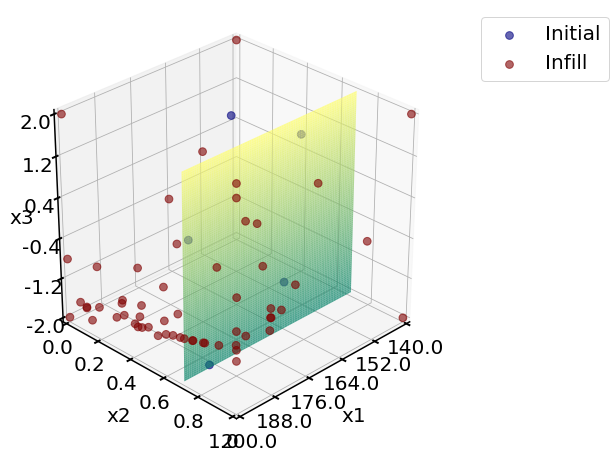

BB sampling points


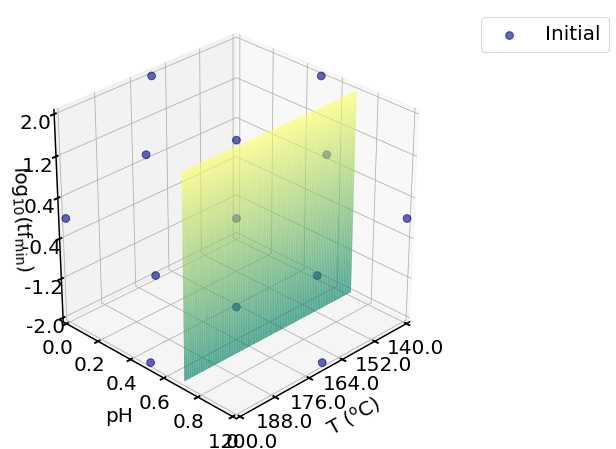

CC sampling points


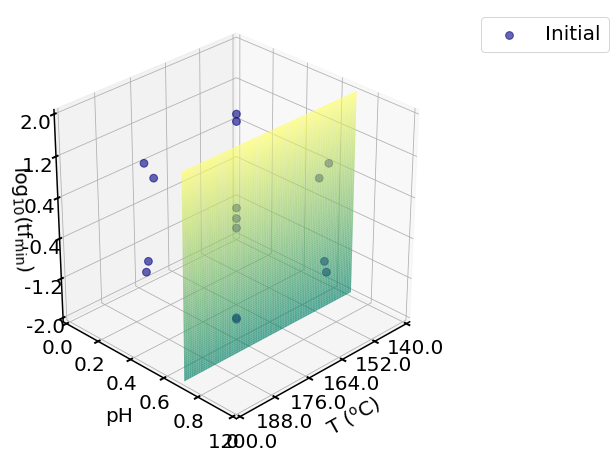

SOBOL sampling points


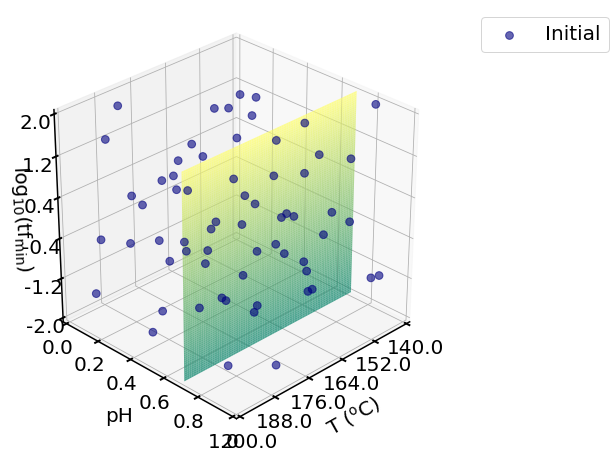

Comparing 4 plans: 


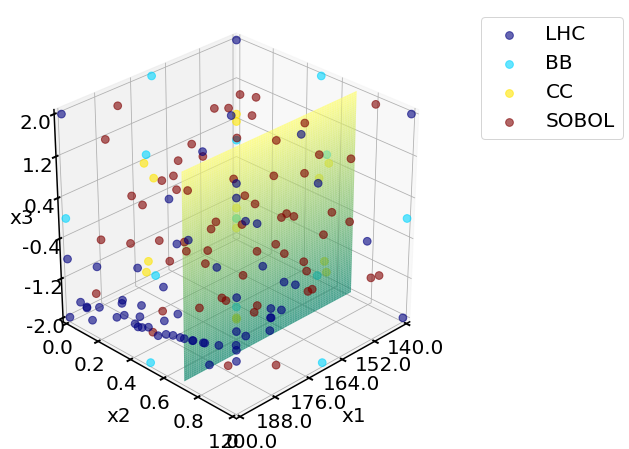

In [6]:
#%% plots 
# Check the sampling points
# Final lhc Sampling
x2_fixed_real = 0.7 # fixed x2 value
x_indices = [0, 2] # 0-indexing, for x1 and x3
print('LHC sampling points')
plotting.sampling_3d_exp(Exp_lhc, 
                         slice_axis = 'y', 
                         slice_value_real = x2_fixed_real)    

print('BB sampling points')
plotting.sampling_3d_exp(Exp_bb,
                         slice_axis = 'y', 
                         slice_value_real = x2_fixed_real,
                         save_fig = True)    

print('CC sampling points')
plotting.sampling_3d_exp(Exp_cc, 
                         slice_axis = 'y', 
                         slice_value_real = x2_fixed_real,
                         save_fig = True)    

print('SOBOL sampling points')
plotting.sampling_3d_exp(Exp_sobol, 
                         slice_axis = 'y', 
                         slice_value_real = x2_fixed_real,
                         save_fig = True)    


# Compare 3 sampling plans
print('Comparing 4 plans: ')
plotting.sampling_3d([Exp_lhc.X, Exp_bb.X, Exp_cc.X, Exp_sobol.X], 
                     X_ranges = X_ranges,
                     design_names = ['LHC', 'BB', 'CC', 'SOBOL'],
                     slice_axis = 'y', 
                     slice_value_real = x2_fixed_real)

By fixing the value of pH (`x2`), we can plot the 2D reponse surfaces by varying T (`x1`) and tf (`x3`). It takes a long time to get the reponses from the objective function. 

To create a heatmap, we generate `mesh_size` (by default = 41, here we set it as 20) test points along one dimension. For a 2D mesh, 20 by 20, i.e. 400 times of evaluation is needed. The following code indicates that evaluting the GP surrogate model is much faster than calling the objective function. 

Objective function heatmap: 


C:\Users\yifan\Anaconda3\envs\torch\lib\site-packages\scipy\integrate\_ode.py:1182: UserWarning:

dopri5: larger nsteps is needed



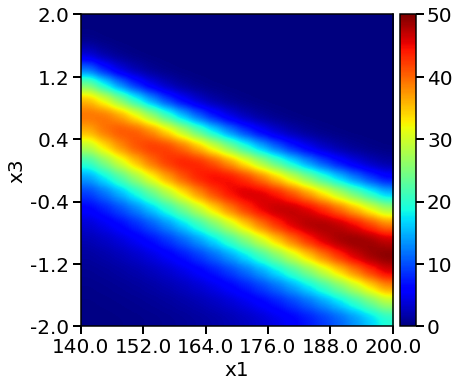

Evaluation of objective function 400 times takes 0.21 min

LHC model heatmap: 


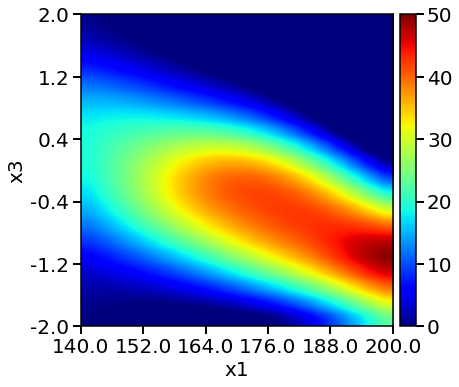

Evaluation of LHC GP model 400 times takes 0.01 min

BB model heatmap: 


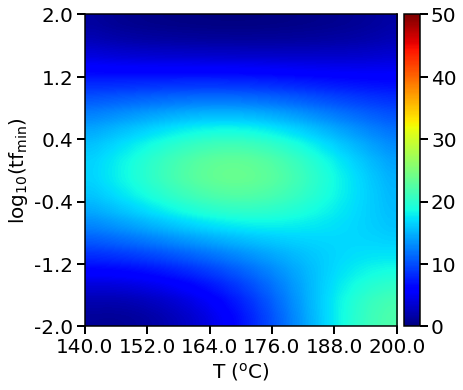

Evaluation of BB GP model 400 times takes 0.01 min

CC model heatmap: 


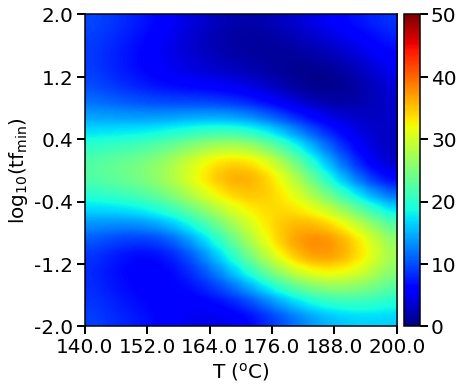

Evaluation of CC GP model 400 times takes 0.01 min

SOBOL model heatmap: 


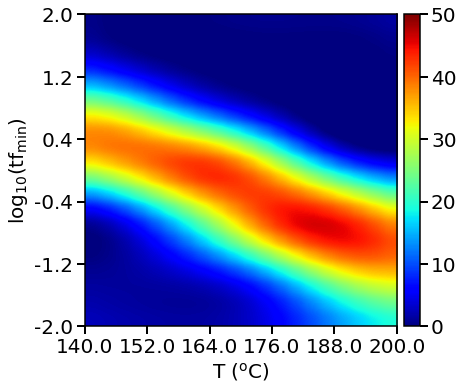

Evaluation of SOBOL GP model 400 times takes 0.01 min



In [7]:
# Reponse heatmaps
# Set X_test mesh size
mesh_size = 20
n_test = mesh_size**2

# Objective function heatmap
# (this takes a long time)
print('Objective function heatmap: ')
start_time = time.time()
plotting.objective_heatmap(objective_func, 
                          X_ranges, 
                          Y_real_range = Y_plot_range, 
                          x_indices = x_indices, 
                          fixed_values_real = x2_fixed_real,
                          mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of objective function {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))


# LHC heatmap 
print('LHC model heatmap: ')
start_time = time.time()
plotting.response_heatmap_exp(Exp_lhc, 
                              Y_real_range = Y_plot_range, 
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of LHC GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))


# Box-Behnken heatmap
print('BB model heatmap: ')
start_time = time.time()
plotting.response_heatmap_exp(Exp_bb, 
                              Y_real_range = Y_plot_range,
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size, 
                              save_fig = True)
end_time = time.time()
print('Evaluation of BB GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60)) 


# central composite heatmap 
print('CC model heatmap: ')
start_time = time.time()
plotting.response_heatmap_exp(Exp_cc, 
                              Y_real_range = Y_plot_range, 
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size,
                              save_fig = True)
end_time = time.time()
print('Evaluation of CC GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))

# Sobol heatmap 
print('SOBOL model heatmap: ')
start_time = time.time()
plotting.response_heatmap_exp(Exp_sobol, 
                              Y_real_range = Y_plot_range, 
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size,
                              save_fig = True)
end_time = time.time()
print('Evaluation of SOBOL GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))

Objective function surface: 


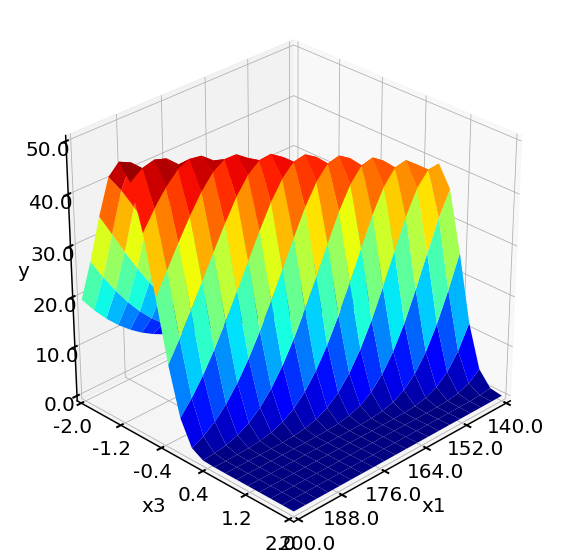

Evaluation of objective function 400 times takes 0.19 min

LHC model surface: 


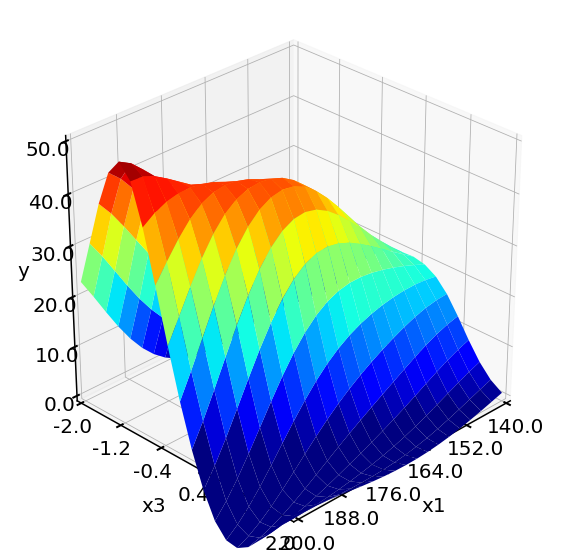

Evaluation of LHC GP model 400 times takes 0.01 min

LHC model surface: 


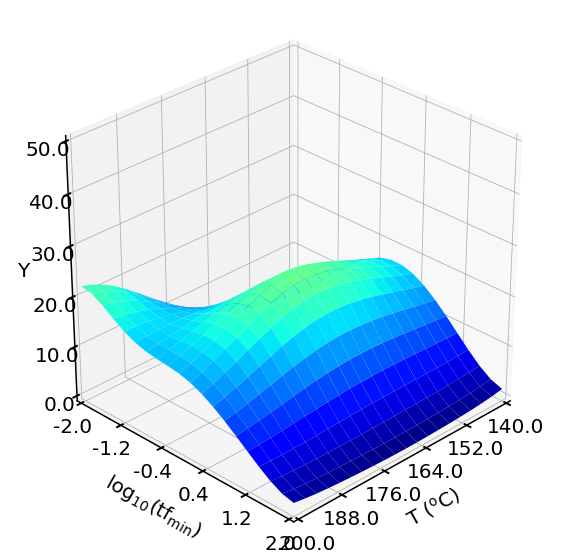

Evaluation of BB GP model 400 times takes 0.01 min

LHC model surface: 


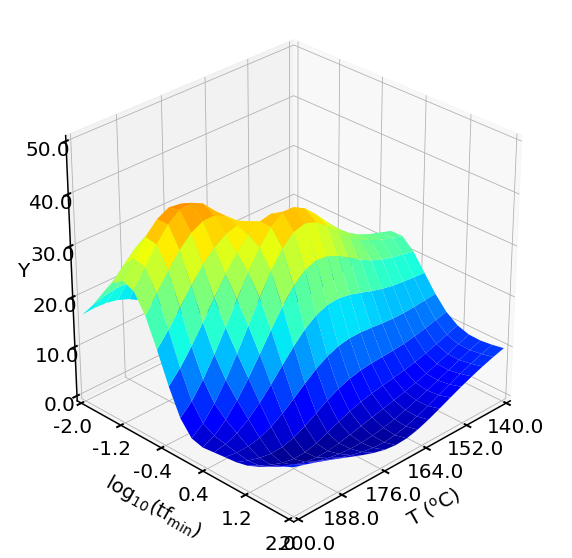

Evaluation of CC GP model 400 times takes 0.01 min

LHC model surface: 


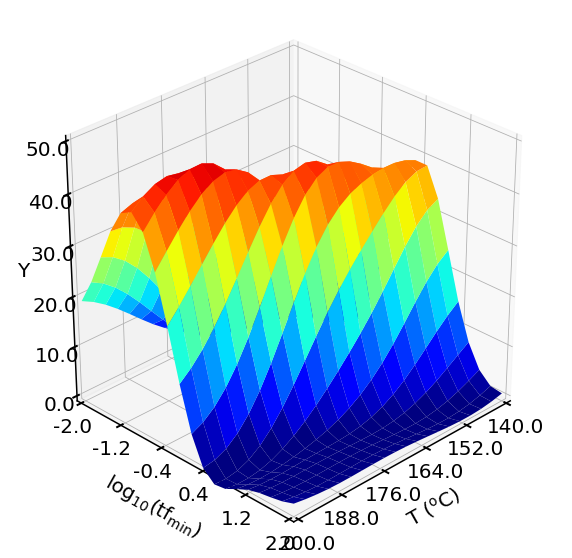

Evaluation of SOBOL GP model 400 times takes 0.01 min



In [8]:
# Suface plots   
# Objective function surface plot  
#(this takes a long time)
print('Objective function surface: ')
start_time = time.time()
plotting.objective_surface(objective_func, 
                          X_ranges, 
                          Y_real_range = Y_plot_range, 
                          x_indices = x_indices, 
                          fixed_values_real = x2_fixed_real, 
                          mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of objective function {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))


# LHC surface plot
print('LHC model surface: ')
start_time = time.time()
plotting.response_surface_exp(Exp_lhc, 
                              Y_real_range = Y_plot_range,
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of LHC GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))

# BB surface plot
print('LHC model surface: ')
start_time = time.time()
plotting.response_surface_exp(Exp_bb, 
                              Y_real_range = Y_plot_range,
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size,
                              save_fig = True)
end_time = time.time()
print('Evaluation of BB GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))

# CC surface plot
print('LHC model surface: ')
start_time = time.time()
plotting.response_surface_exp(Exp_cc, 
                              Y_real_range = Y_plot_range,
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size,
                              save_fig = True)
end_time = time.time()
print('Evaluation of CC GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))

# SOBOL surface plot
print('LHC model surface: ')
start_time = time.time()
plotting.response_surface_exp(Exp_sobol, 
                              Y_real_range = Y_plot_range,
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size,
                              save_fig = True)
end_time = time.time()
print('Evaluation of SOBOL GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))

## 7. Export the optimum

Compare all plans in terms optimum discovered in each trial.

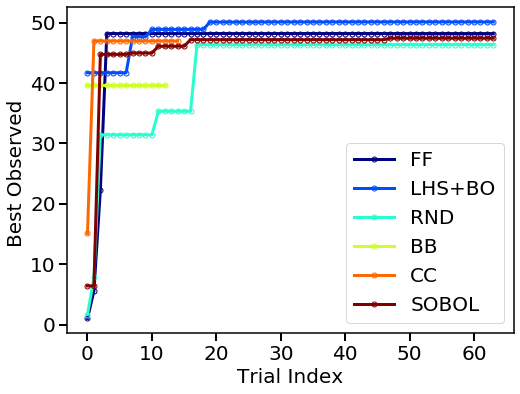

In [9]:
plotting.opt_per_trial([Exp_ff.Y_real, Exp_lhc.Y_real, Exp_rnd.Y_real, Exp_bb.Y_real, Exp_cc.Y_real, Exp_sobol.Y_real], 
                       design_names = ['FF', 'LHS+BO', 'RND', 'BB', 'CC', 'SOBOL'])

## 8. Compared to Ax

Here we compare LHS+BO generated by NEXTorch to [Ax](https://ax.dev/), both are wrappers around [Botorch](https://botorch.org/) for Bayesian Optimization. 

A side-by-side comparsion is shown below. One can see that both methods converge to the similar optima. 

In [26]:
# ax functions from the loop API
from ax.service.managed_loop import optimize

# ax functions from the developer API
from ax import (
    Data,
    ParameterType, 
    RangeParameter,
    SearchSpace, 
    SimpleExperiment, 
)
from ax.modelbridge.registry import Models


# Objective function
def objective_function(
    X_real, # dict of parameter names to values of those parameters
    weight=None, # optional weight argument
):  
    # given a dict of parameter , compute a value for each metric
    x1 = X_real[x_name_simple[0]]
    x2 = X_real[x_name_simple[1]]
    x3 = X_real[x_name_simple[2]]
    
    Conditions = {'T_degC (C)': x1, 'pH': x2, 'tf (min)' : 10**x3}
    yi, _ = Reactor(**Conditions) # only keep the first output  
      
    # a dictionary of objective names to tuples of mean and standard error for those objectives
    # the initial standard error is assume to be 0
    return {Y_name_with_unit: (yi, 0)}  


# set the total number of sampling points
n_total = 64
# optimization function main body

n_init = 10 #initial experiments
n_samples_per_trial = 1 # number of sampling points per trial
n_trials = int((n_total-n_init)/n_samples_per_trial) #number of trials

# define the parameter space (or search space)
search_space = SearchSpace(
    parameters=[
        RangeParameter(
            name=x_name_i, parameter_type=ParameterType.FLOAT, lower=X_range_i[0], upper=X_range_i[1]
        )
        for x_name_i, X_range_i in zip(x_name_simple, X_ranges)
    ]
)

# initialize a SimpleExperiment object
experiment_ax = SimpleExperiment(
    name="PFR",
    search_space=search_space,
    evaluation_function=objective_function,
    objective_name=Y_name_with_unit,
    minimize=False,
)

# Define Initial Sobol sampling plan
print("Running Sobol initialization trials...")
sobol = Models.SOBOL(experiment_ax.search_space)
for i in range(n_init):
    experiment_ax.new_trial(generator_run=sobol.gen(1))

# Show the initial sampling points
print("The initial sampling data: ")
data_all = experiment_ax.eval().df

# Optimization loop main body
for i in range(n_trials):
    print(f"Running GP+EI optimization trial {i+1}/{n_trials}...")
    # Import the dataframe containing all previous point
    # Reinitialize GP+EI model at each step with the updated data
    data_new = Data(data_all)
    model_ax = Models.BOTORCH(experiment=experiment_ax, data=data_new)
    generator_run=model_ax.gen(n=1)
    best_trial, _ = generator_run.best_arm_predictions
    experiment_ax.new_batch_trial(generator_run=generator_run)
    
    # Export the next sampling points into a dataframe
    data_all = experiment_ax.eval().df
    data_next = data_all[-n_samples_per_trial:]

    
print("Done!")
best_parameters = best_trial.parameters
Y_real_ax = np.array([data_all['mean']]).T

Running Sobol initialization trials...
The initial sampling data: 
Running GP+EI optimization trial 1/54...
Running GP+EI optimization trial 2/54...
Running GP+EI optimization trial 3/54...
Running GP+EI optimization trial 4/54...
Running GP+EI optimization trial 5/54...
Running GP+EI optimization trial 6/54...
Running GP+EI optimization trial 7/54...
Running GP+EI optimization trial 8/54...
Running GP+EI optimization trial 9/54...
Running GP+EI optimization trial 10/54...
Running GP+EI optimization trial 11/54...
Running GP+EI optimization trial 12/54...
Running GP+EI optimization trial 13/54...
Running GP+EI optimization trial 14/54...
Running GP+EI optimization trial 15/54...
Running GP+EI optimization trial 16/54...
Running GP+EI optimization trial 17/54...
Running GP+EI optimization trial 18/54...
Running GP+EI optimization trial 19/54...
Running GP+EI optimization trial 20/54...
Running GP+EI optimization trial 21/54...
Running GP+EI optimization trial 22/54...
Running GP+EI opti

C:\Users\yifan\Anaconda3\envs\torch\lib\site-packages\scipy\integrate\_ode.py:1182: UserWarning:

dopri5: larger nsteps is needed



Running GP+EI optimization trial 41/54...
Running GP+EI optimization trial 42/54...
Running GP+EI optimization trial 43/54...
Running GP+EI optimization trial 44/54...
Running GP+EI optimization trial 45/54...
Running GP+EI optimization trial 46/54...
Running GP+EI optimization trial 47/54...
Running GP+EI optimization trial 48/54...
Running GP+EI optimization trial 49/54...
Running GP+EI optimization trial 50/54...
Running GP+EI optimization trial 51/54...
Running GP+EI optimization trial 52/54...
Running GP+EI optimization trial 53/54...
Running GP+EI optimization trial 54/54...
Done!


Compare two plans in terms optimum discovered in each trial.

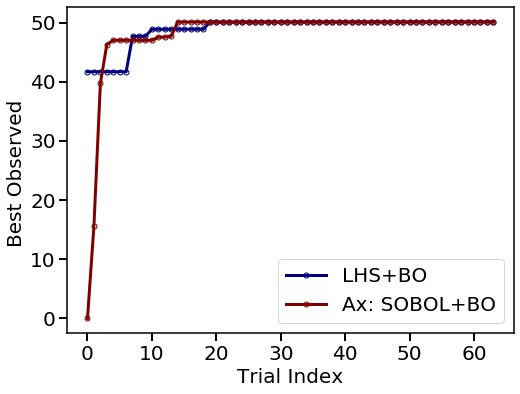

In [27]:
plotting.opt_per_trial([Exp_lhc.Y_real,  Y_real_ax], 
                       design_names = ['LHS+BO', 'Ax: SOBOL+BO'])

Obtain the optimum from each method. 

In [29]:
# lhc+BO optimum
y_opt_lhc, X_opt_lhc, index_opt_lhc = Exp_lhc.get_optim()
data_opt_lhc = io.np_to_dataframe([X_opt_lhc, y_opt_lhc], var_names)

print('From LHS + Bayesian Optimization, ')
display(data_opt_lhc)

# Ax: SOBOL+BO optimum
y_opt_ax = np.max(Y_real_ax) 
X_opt_ax = np.array(list(best_parameters.values()))
data_opt_ax = io.np_to_dataframe([X_opt_ax, y_opt_ax], var_names)
print('From Ax: SOBOL + Bayesian Optimization, ')
display(data_opt_ax)

From LHS + Bayesian Optimization, 


,T ($\rm ^{o}C $),pH,$\rm log_{10}(tf_{min})$,Yield %
0,200.0,0.428583,-1.412632,50.10161


From Ax: SOBOL + Bayesian Optimization, 


,T ($\rm ^{o}C $),pH,$\rm log_{10}(tf_{min})$,Yield %
0,200.0,0.592884,-1.245443,50.100341
